In [10]:
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pyplot as plt
import csv
import numpy.ma as ma

In [19]:
# THIS IS ALL OF THE FUNCTIONS BEHIND THE SCENES

# This is the general equation that we are modeling
# param is a list, where param[0] = a, param[1] = b, param[2] = d
# x is also a list, where x[0] = TMP, x[1] = flow rate
def model(param, x):
    return (param[0] * x[1]) / (x[0] - x[1] * param[1]) + x[1] * param[2]

# This is the objective function that we want to be as close to 0 as possible
# Aka, we want the model - y to be 0
def objective_function(param, x, y):
    return model(param, x) - y

# This is the Jacobian of the above model, with partial derivatives taken with
# respect to the parameters
def jac(param, x, y):
    # We establish an empty 2D array (input size x num parameters)
    J = np.empty((len(x[0]), len(param)))
    # dF/da
    J[:, 0] = x[1, :] / (x[0, :] - x[1, :] * param[1])
    # dF/db
    J[:, 1] = (x[1, :]**2 * param[0]) / (x[0, :] - x[1, :] * param[1])**2
    # dF/dd
    J[:, 2] = x[1, :]
    return J

# Create a model from the data input
def create_model(data):
    # We read in the data from the parameters, generated above in get_data
    y_data = np.array(data['y'], dtype=np.float)
    x_1_data = np.array(data['x_1'], dtype=np.float)
    x_2_data = np.array(data['x_2'], dtype=np.float)
    # We have to combine the multiple dependent variables into a single
    x_data = np.array([x_1_data, x_2_data])

    # These are our initial guesses for a, b, and d respectively
    initial_guesses = np.array([0.01, -0.1, 0.01])

    # Run our least_squares analysis
    res = least_squares(objective_function, initial_guesses, jac=jac, args=(x_data, y_data), verbose=1)

    # Return the 'x' values, which are the parameters it has learned
    return res.x


# Create a graph from the model created
# DON'T CHANGE THIS
def generate_graph(data, results):
    # Find unique flowrates in the data
    flowrates = list(set(data['x_2']))

    # We want a bounding x value
    max_tmp = float(max(data['x_1'])) * 1.5

    # We put it all in a dictionary
    for flowrate in flowrates:
        # Create a linspace of tmps, as well as a list of equal length of the one flowrate
        x_tmp_values = np.linspace(0, max_tmp, 50)
        x_flow_values = np.full((50), flowrate, dtype=np.float)
        y_data = model(results, np.array([x_tmp_values, x_flow_values]))

        plt.plot(x_tmp_values, y_data, 'o', markersize=2)

    # Just some annoying calculations to plot the original data together
    for flowrate in flowrates:
        x_1 = np.array(data['x_1'], dtype=np.float)
        x_2 = np.array(data['x_2'])
        y = np.array(data['y'], dtype=np.float)
        x_values = ma.masked_where(x_2 != flowrate, x_1)
        x_values = x_values[~x_values.mask]
        y_values = ma.masked_where(x_2 != flowrate, y)
        y_values = np.array(y_values[~y_values.mask])

        plt.plot(x_values, y_values)

    # Plot with the flowrates attached
    plt.legend([a + ' model' for a in flowrates]+[a + ' original' for a in flowrates])
    plt.ylabel('Steady-state permeate flux (L/(m^2*h))')
    plt.xlabel('TMP (bar)')
    plt.show()

# Get the data from the CSV file
# DON'T CHANGE THIS
def get_data(file_name):
    with open(file_name) as f:
        csv_reader = csv.reader(f, delimiter=',')
        y = []
        x_1 = []
        x_2 = []
        next(csv_reader)
        for row in csv_reader:
            x_1.append(row[0])
            x_2.append(row[1])
            y.append(row[2])

        return {'y': y, 'x_1': x_1, 'x_2': x_2}

In [25]:
import os
notebook_path = os.path.abspath("model_training.ipynb")  # HERE IS WHERE YOU PUT THE DIFFERENT FILE NAME
train_csv = os.path.join(os.path.dirname(notebook_path), "example-data.csv")

# Get the data from the CSV
data = get_data(train_csv)

In [26]:
# Get the parameter results
results = create_model(data)

`ftol` termination condition is satisfied.
Function evaluations 35, initial cost 3.5647e+03, final cost 2.1366e+02, first-order optimality 1.99e+01.


For the equation: (flowrate * a) / (tmp - flowrate * b) + flowrate * c
a = -0.002749688274522191
b = -8.301768508494198e-05
c = 0.03741113513434366


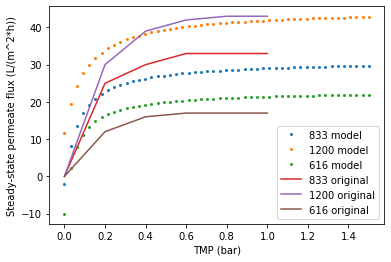

In [27]:
# Output the new parameters
print('For the equation: (flowrate * a) / (tmp - flowrate * b) + flowrate * c')
print('a = {}'.format(results[0]))
print('b = {}'.format(results[1]))
print('c = {}'.format(results[2]))

print(results)



# Graph the data, if requested
generate_graph(data, results)